In [38]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow

In [39]:
history_points = 50

def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('date', axis=1)
    data = data.drop('Adj Close', axis=1)
    data = data.drop('Volume', axis=1)
    data = data.drop('change', axis=1)
    data = data.drop('Change-close', axis=1)
    data = data.drop(0, axis=0)

    print(data)
    data = data.values

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)

    def calc_ema(values, time_period):
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalised:
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser

In [40]:
ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('niftymid--50.csv')

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)

             Open         High          Low        Close
1     2969.250000  2977.300049  2942.350098  2951.850098
2     2953.600098  2957.149902  2904.250000  2912.800049
3     2916.850098  2933.100098  2863.649902  2868.100098
4     2865.250000  2867.850098  2772.800049  2783.649902
5     2785.800049  2791.300049  2703.800049  2708.850098
...           ...          ...          ...          ...
1623  4778.049805  4780.299805  4627.600098  4711.200195
1624  4709.049805  4772.649902  4689.450195  4748.399902
1625  4774.500000  4780.100098  4624.649902  4641.649902
1626  4649.100098  4676.000000  4601.149902  4658.649902
1627  4682.350098  4730.250000  4677.799805  4687.500000

[1627 rows x 4 columns]
(1419, 50, 4)
(158, 50, 4)


In [41]:
# model architecture

lstm_input = Input(shape=(history_points, 4), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='mean_squared_error')
history = model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=30, shuffle=False, validation_split=0.1)

Epoch 1/30
40/40 [==============================] - 11s 87ms/step - loss: 0.0754 - val_loss: 0.0156
Epoch 2/30
40/40 [==============================] - 2s 39ms/step - loss: 0.0086 - val_loss: 7.7128e-04
Epoch 3/30
40/40 [==============================] - 1s 32ms/step - loss: 0.0125 - val_loss: 6.2765e-04
Epoch 4/30
40/40 [==============================] - 1s 26ms/step - loss: 0.0111 - val_loss: 4.8907e-04
Epoch 5/30
40/40 [==============================] - 1s 26ms/step - loss: 0.0079 - val_loss: 9.4245e-04
Epoch 6/30
40/40 [==============================] - 1s 27ms/step - loss: 0.0050 - val_loss: 6.9878e-04
Epoch 7/30
40/40 [==============================] - 1s 25ms/step - loss: 0.0030 - val_loss: 3.5427e-04
Epoch 8/30
40/40 [==============================] - 1s 24ms/step - loss: 0.0025 - val_loss: 4.2036e-04
Epoch 9/30
40/40 [==============================] - 1s 25ms/step - loss: 0.0025 - val_loss: 4.6211e-04
Epoch 10/30
40/40 [==============================] - 1s 25ms/step - loss: 0.

In [42]:
y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

50/50 [==============================] - 1s 11ms/step
2263.5265606284365


In [43]:
import matplotlib.pyplot as plt

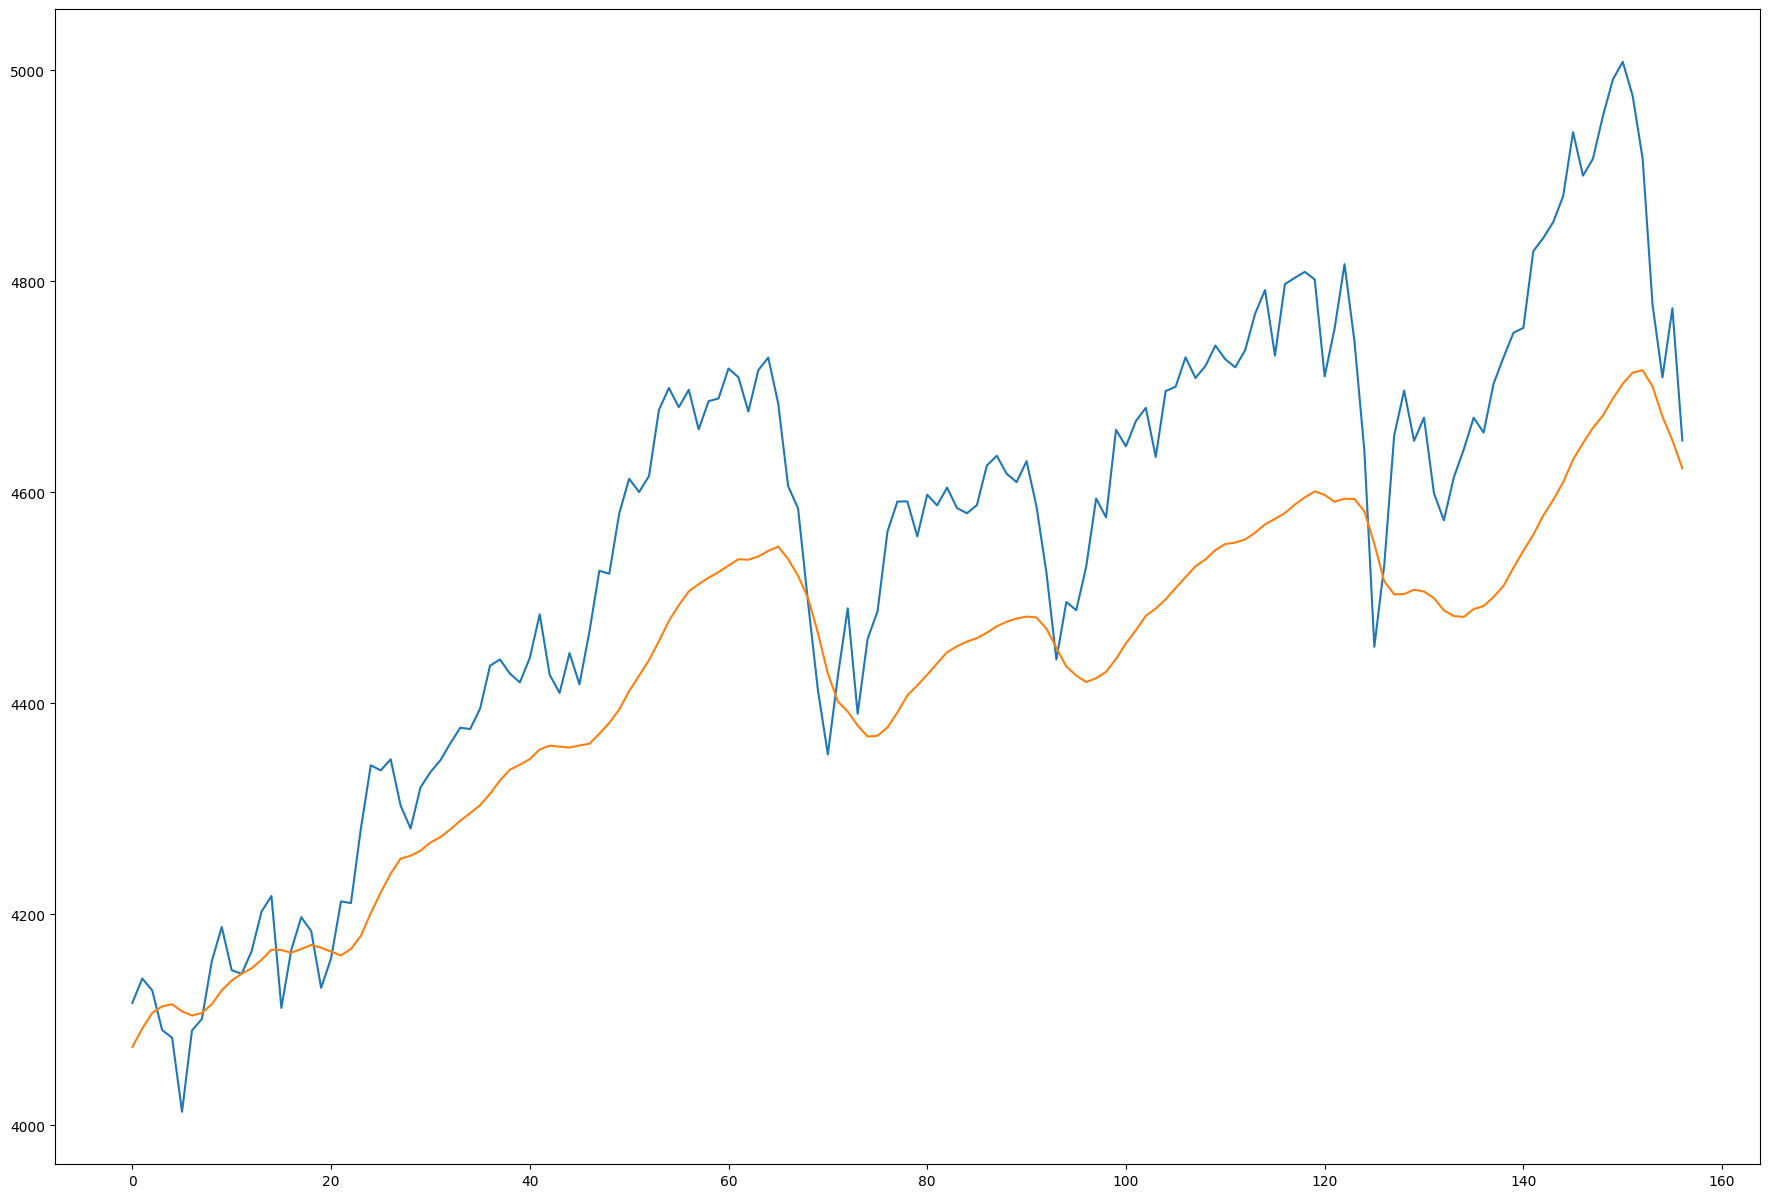

In [44]:
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real2')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

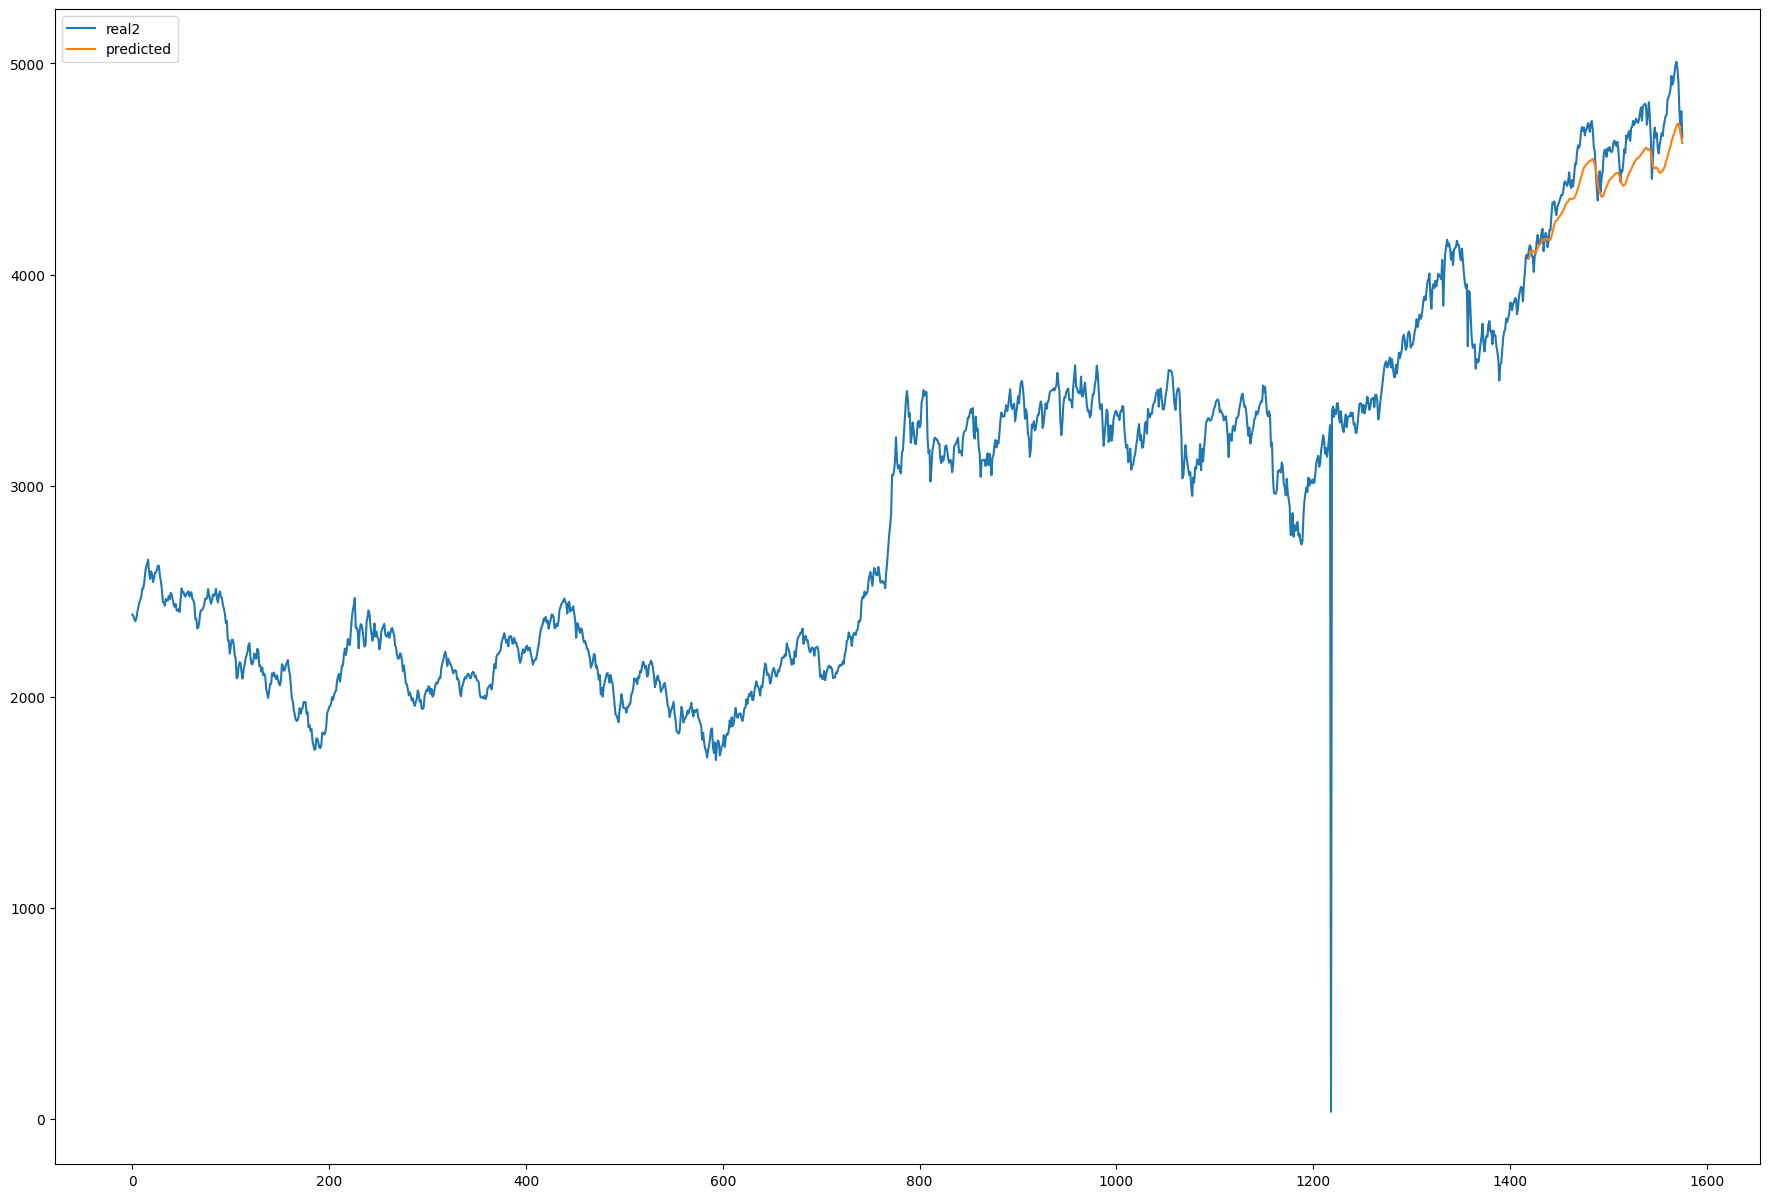

In [45]:
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y[start:end], label='real2')
#real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(range(1419, 1419+len(unscaled_y_test)-1), y_test_predicted[start:end], label='predicted')

plt.legend()

plt.show()

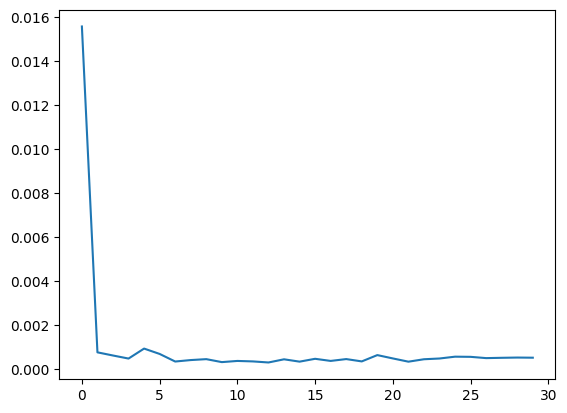

In [46]:
plt.plot(history.history['val_loss'])

In [47]:
model.save(f'basic_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
